[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.11.0. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

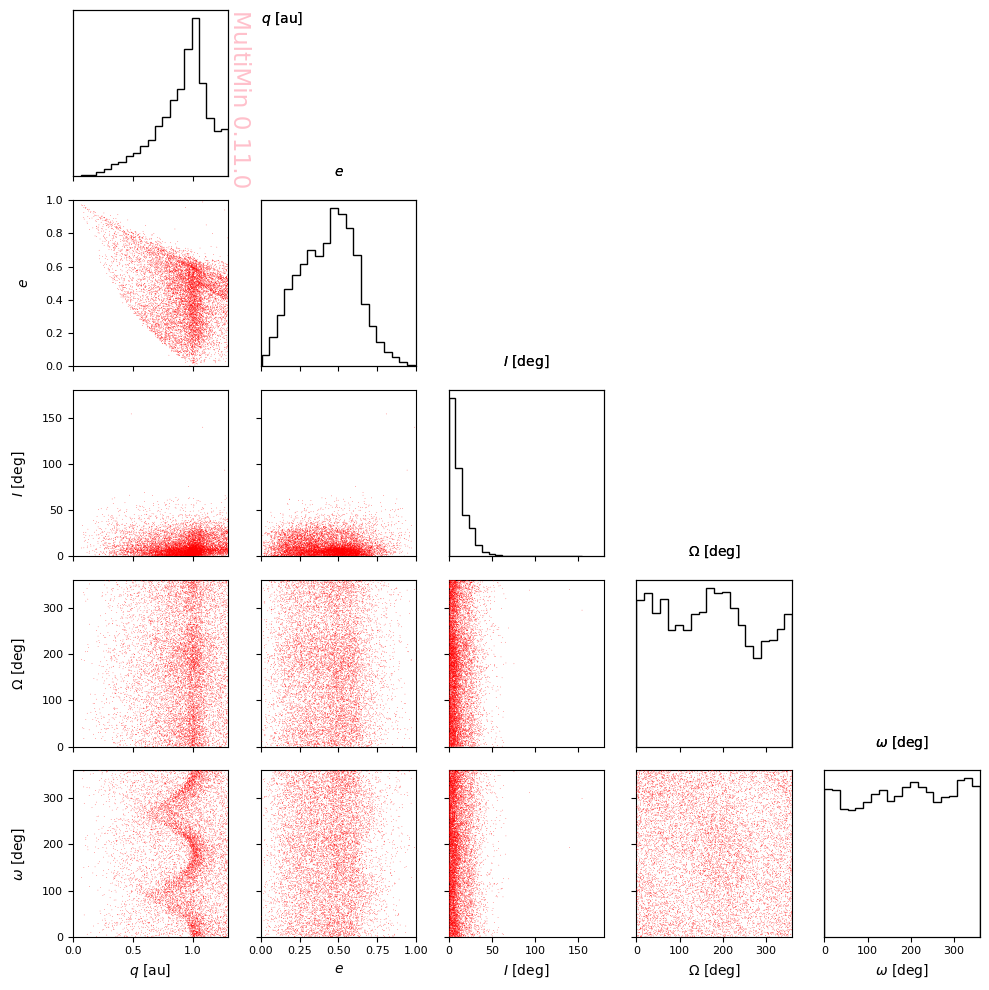

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2,marginals=True)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [5]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

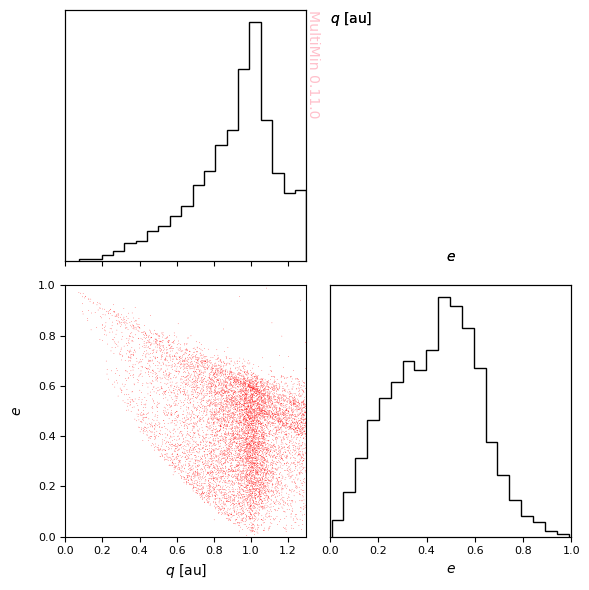

In [6]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3,marginals=True)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [7]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.3068756824249158
FitMoG.fit_data executed in 0.11007905006408691 seconds
Elapsed time since last call: 117.016 ms
-log(L)/N = -0.5244338910221313


And check the fit result:

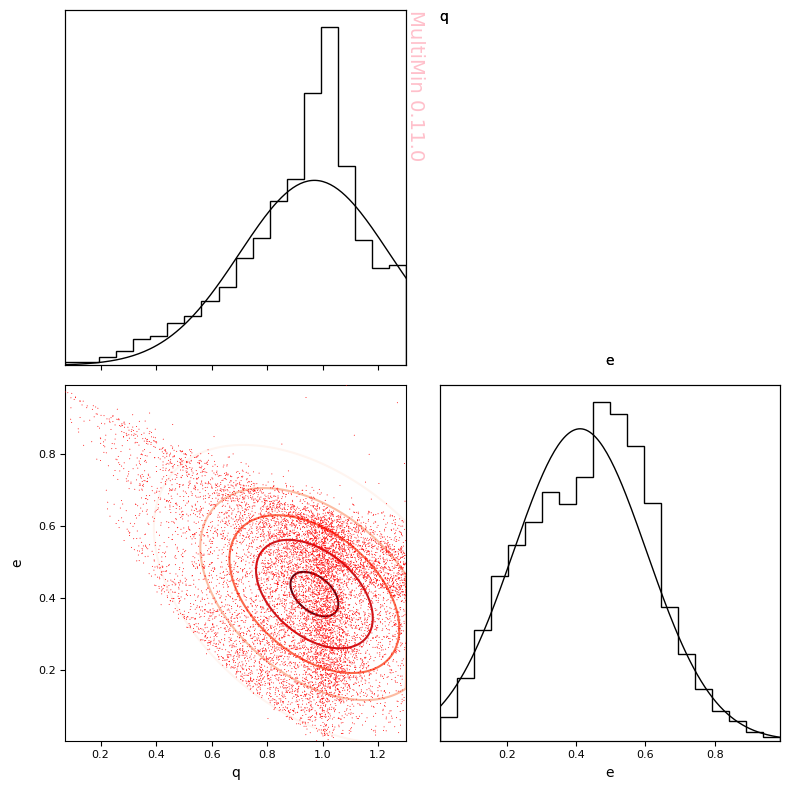

In [8]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(
    properties=properties,
    #pargs=hargs,
    pargs=None,
    sargs=sargs,
    cargs=cargs,
    figsize=4,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [9]:
F_qe_1.mog.tabulate()

w      mu_1      mu_2   sigma_1   sigma_2    rho_12
component                                                       
1          1.0  0.970371  0.411307  0.269551  0.192231 -0.442373

We can do it better increasing the number of normals:

In [10]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.2467050374999516
Iterations:
Iter 0:
	Vars: [-1.4, -1.3, -1.3, -1.3, -1.5, 0.47, 0.14, 0.81, 0.31, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.67, 0.64, 0.71, 0.44, 1.1]
	LogL/N: 2.143636138691089


Iter 50:
	Vars: [-2, -1.2, -0.98, -0.86, -2, 1, 0.28, 0.79, 0.26, 1, 0.39, 1.1, 0.52, 1, 0.52, -5.1, -4.6, -3.8, -4, -4.1, -4.2, -3.1, -4.1, -4.2, -4.9, -1.6, -2.6, -1.5, -3.5, 0.59]
	LogL/N: -0.6867544967083277


Iter 100:
	Vars: [-1.7, -1.9, -0.64, -0.57, -2.2, 1, 0.3, 0.71, 0.27, 0.95, 0.35, 1.2, 0.47, 1, 0.53, -5.5, -4.1, -4, -4.2, -3.9, -4.2, -3, -4, -4.4, -4.9, -0.19, -2.9, -1.4, -3.6, 0.3]
	LogL/N: -0.7008587252551841


Iter 150:
	Vars: [-1.4, -2.1, -0.49, -0.73, -2.2, 1, 0.31, 0.75, 0.23, 0.93, 0.37, 1.2, 0.49, 1, 0.53, -5.3, -4.2, -4, -4.4, -3.6, -4.1, -3.1, -4, -4.4, -5, -0.21, -3.2, -1.7, -3.7, 0.38]
	LogL/N: -0.706304011706478


Iter 200:
	Vars: [-1.3, -2.2, -0.52, -0.78, -2.2, 1, 0.32, 0.75, 0.22, 0.93, 0.37, 1.2, 0.49, 1, 0.54, -5.3, -4.2, -4.1, -4.4, -3.6, -4.1, -3.1, -4, -4.2, -5, -0.25, -3.2, -1.8, -3.8, 0.47]
	LogL/N: -0.7070097191489924


Iter 250:
	Vars: [-1.2, -2.1, -0.49, -0.87, -2.2, 1, 0.32, 0.75, 0.23, 0.93, 0.38, 1.2, 0.49, 1, 0.54, -5.2, -4.2, -4.1, -4.4, -3.6, -4.1, -3, -4, -4.2, -5.1, -0.23, -3.1, -1.7, -3.9, 0.45]
	LogL/N: -0.7071902591588887


Iter 300:
	Vars: [-1.2, -2.1, -0.45, -0.88, -2.2, 1, 0.32, 0.75, 0.23, 0.93, 0.38, 1.2, 0.48, 1, 0.55, -5.2, -4.2, -4.1, -4.4, -3.6, -4.1, -3, -4, -4.2, -5.1, -0.26, -3, -1.7, -4, 0.39]
	LogL/N: -0.7072859994491943


Iter 350:
	Vars: [-1.2, -2.1, -0.44, -0.89, -2.2, 1, 0.32, 0.75, 0.22, 0.93, 0.38, 1.2, 0.47, 1, 0.55, -5.2, -4.2, -4.1, -4.4, -3.6, -4.1, -3, -4, -4.2, -5.2, -0.26, -3, -1.7, -4, 0.33]
	LogL/N: -0.7073013854843637


Iter 400:
	Vars: [-1.2, -2.2, -0.42, -0.93, -2.2, 1, 0.32, 0.75, 0.22, 0.93, 0.38, 1.2, 0.47, 1, 0.55, -5.2, -4.2, -4.1, -4.4, -3.6, -4.1, -3, -3.9, -4.2, -5.2, -0.26, -3.1, -1.7, -4, 0.22]
	LogL/N: -0.7073208979040063


Iter 442:
	Vars: [-1.2, -2.2, -0.43, -0.96, -2.2, 1, 0.32, 0.75, 0.22, 0.93, 0.38, 1.2, 0.47, 1, 0.55, -5.2, -4.2, -4.1, -4.4, -3.6, -4.1, -3, -3.9, -4.1, -5.2, -0.26, -3.1, -1.7, -4.1, 0.096]
	LogL/N: -0.7073308400233118
FitMoG.fit_data executed in 21.65901494026184 seconds
Elapsed time since last call: 21.6611 s
-log(L)/N = -0.7073308400233118


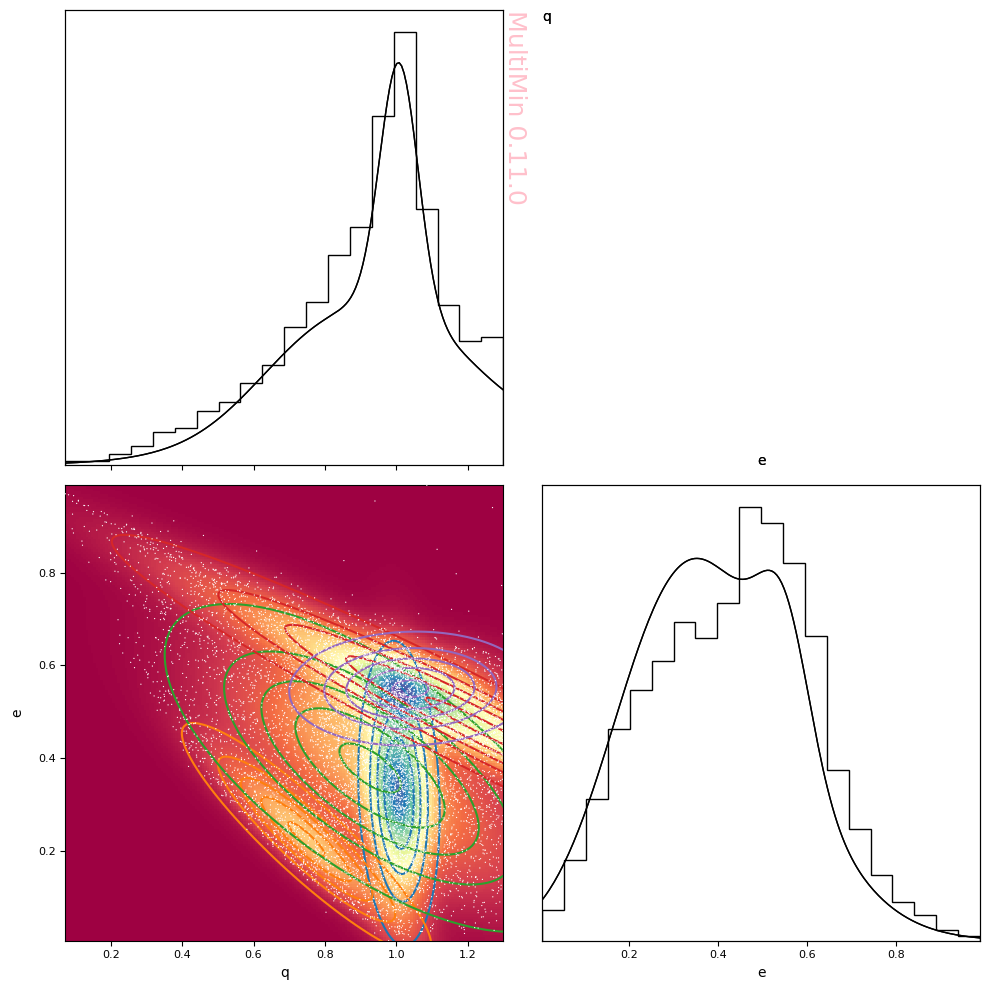

In [11]:
properties = ["q","e"]
sargs = dict(s=0.8,edgecolor='None',color='w')
pargs = dict(cmap='Spectral')
cargs = dict(decomp=True, legend=False)
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    cargs=cargs,
    figsize=5,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_decomposition.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [12]:
neas_sample = F.mog.rvs(len(data_neas_qe))

MixtureOfGaussians.rvs executed in 0.6891939640045166 seconds


And plot it:

Text(0.5, 1.0, 'Original data')

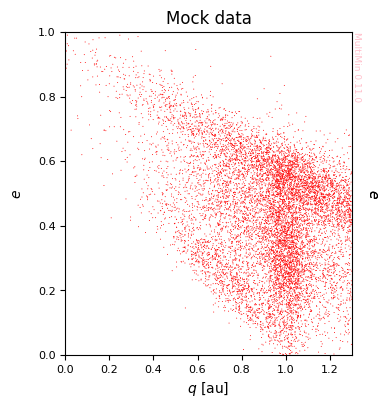

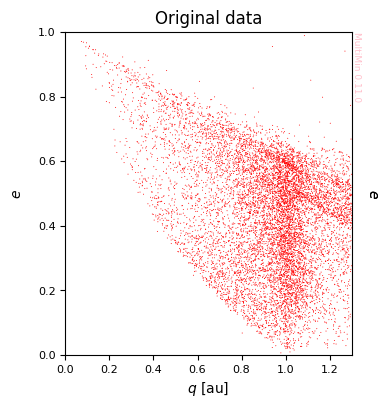

In [13]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

w      mu_q      mu_e   sigma_q   sigma_e    rho_qe
component                                                            
3          0.358191  0.926454  0.378686  0.268049  0.164914 -0.689170
4          0.251555  1.233433  0.469998  0.480291  0.191910 -0.966249
1          0.202339  1.007387  0.323889  0.053076  0.153476 -0.130767
2          0.094210  0.748569  0.224892  0.162792  0.116879 -0.911335
5          0.093704  1.039400  0.549990  0.158135  0.057268  0.047740

In [15]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 1.007387
    mu1_e = 0.323889
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.002817, -0.001065], [-0.001065, 0.023555]]
    Z1 = 0.982581
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.748569
    mu2_e = 0.224892
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.026501, -0.01734], [-0.01734, 0.013661]]
    Z2 = 0.972829
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.926454
    mu3_e = 0.378686
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.07185, -0.030465], [-0.030465, 0.027197]]
    Z3 = 0.914813
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.233433
    mu4_e = 0.469998
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.23068, -0.089062], [-0.089062, 0.036829]]
    Z4 = 0.549621
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.0394
    mu5_e = 0.54999
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.025007, 0.000432], [0.000432, 0.00328]]
    Z5 = 0.95

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 132.2308957330721


FitMoG.fit_data executed in 0.2105259895324707 seconds
-log(L)/N = 3.4878308258397257


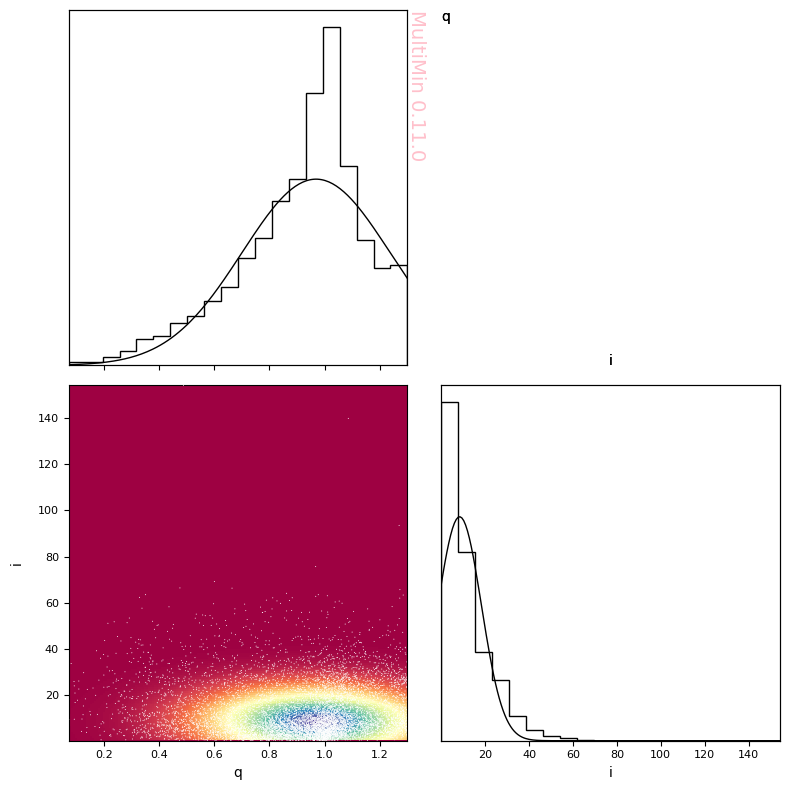

In [16]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
sargs=dict(s=0.5,edgecolor='None',color='w')
pargs=dict(cmap='Spectral')
G=F_qi_1.plot_fit(properties=properties,pargs=pargs,sargs=sargs,figsize=4,marginals=True)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 134.98454046549466
FitMoG.fit_data executed in 0.08261513710021973 seconds
-log(L)/N = 3.3187479708488783


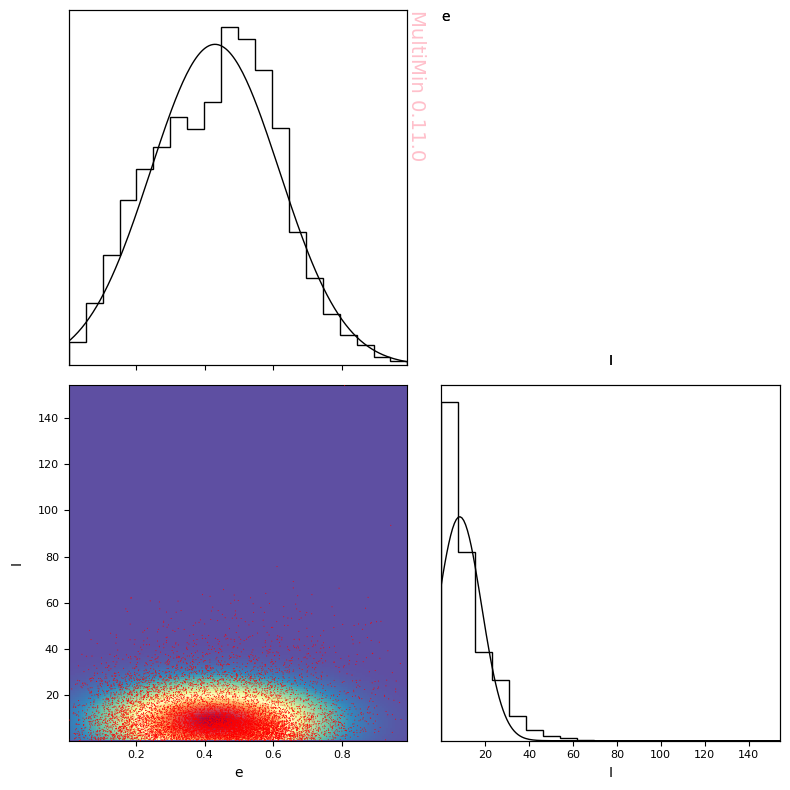

In [17]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4,marginals=True)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [18]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

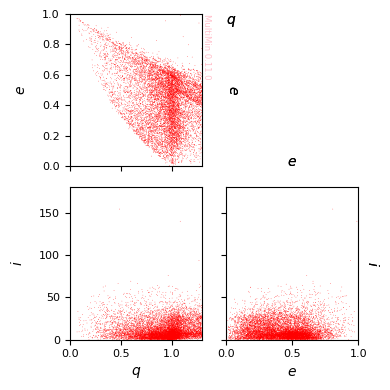

In [19]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.24853810159595


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.3748600482940674 seconds
-log(L)/N = -1.0691055625881813


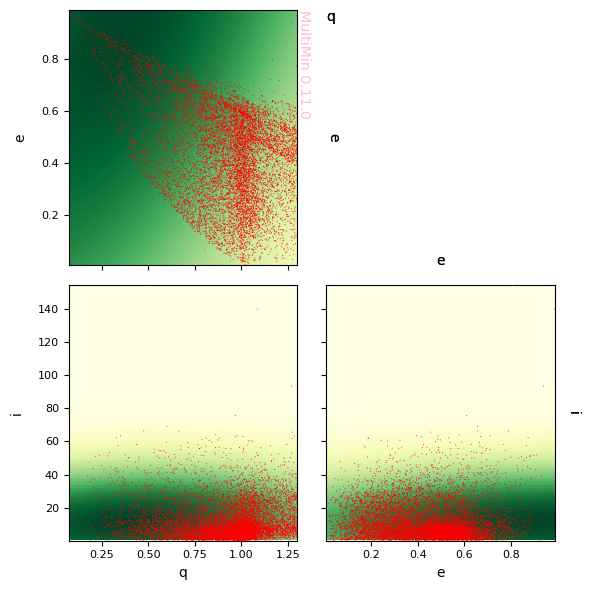

In [20]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [21]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
#fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.2485378214994


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.2636721134185791 seconds
-log(L)/N = -2.3506682316998857


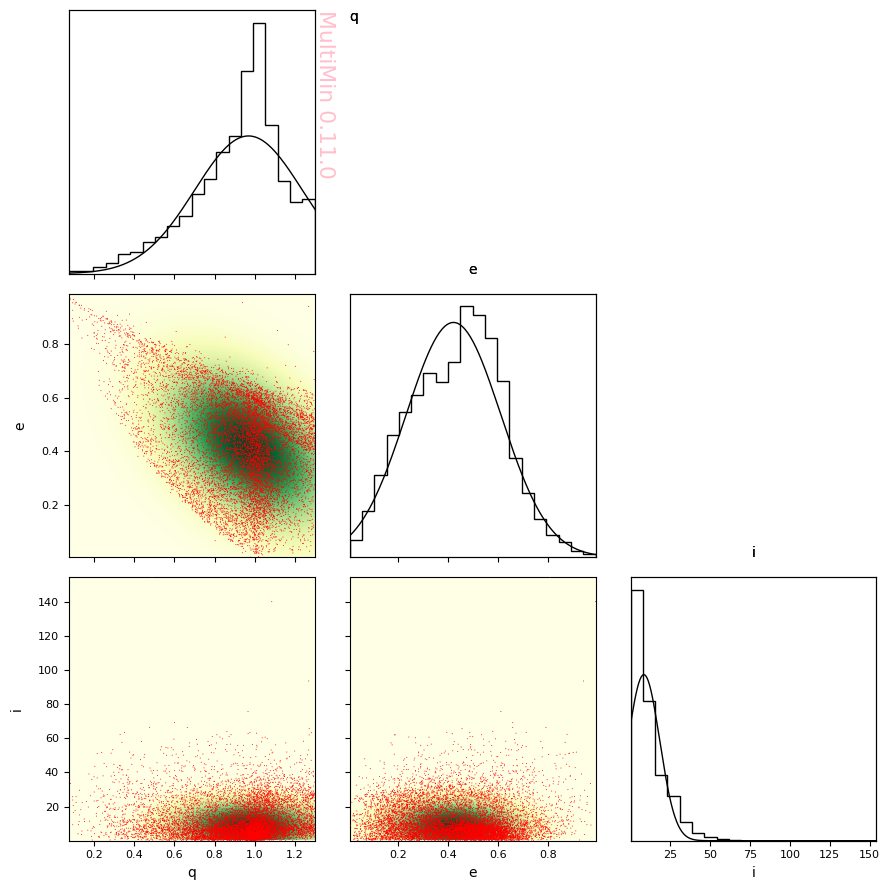

In [22]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3,
    marginals=True
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 337.1884378635759


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 6.2277140617370605 seconds


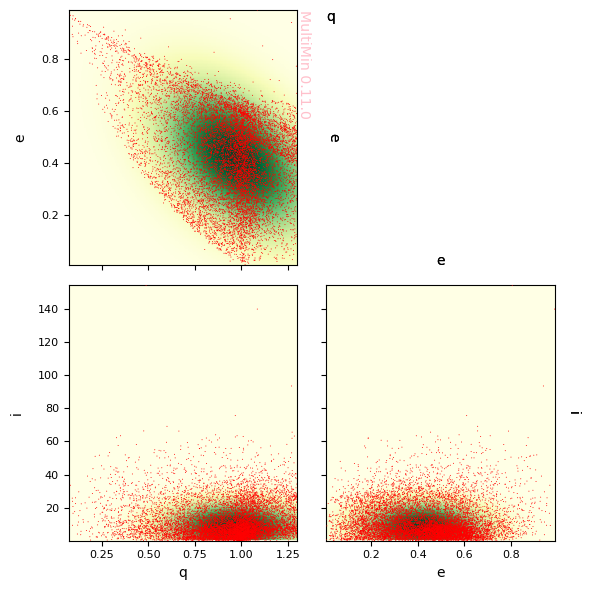

In [23]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

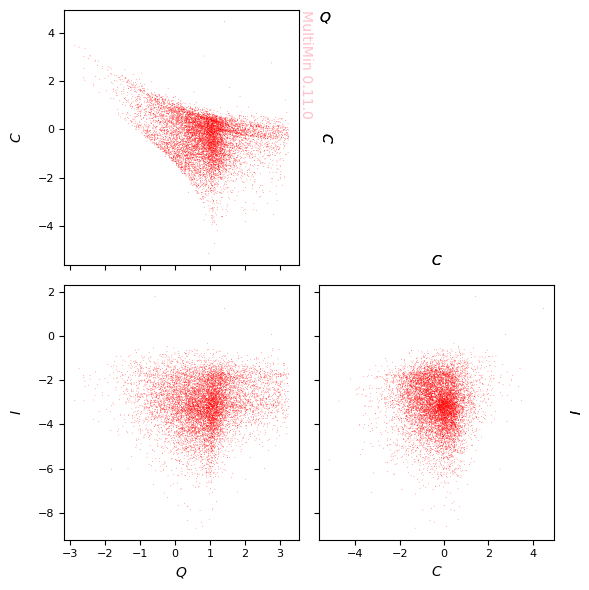

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

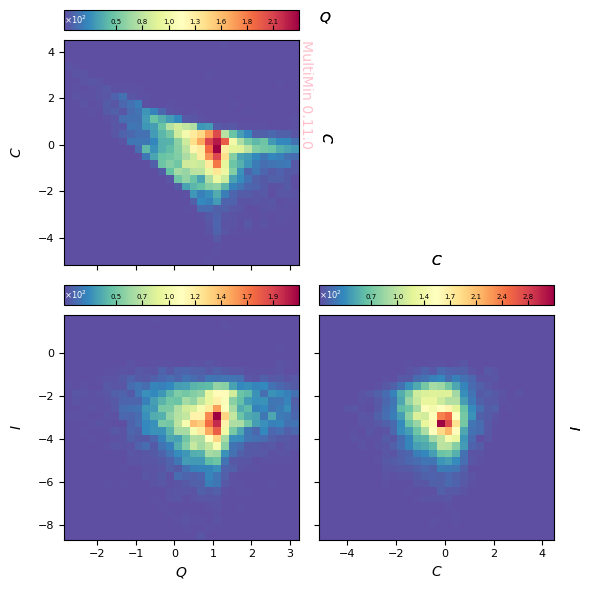

In [26]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.993694115753112


The fitter holds an initial MoG that will be optimized:

In [28]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.15134882926940918 seconds
Elapsed time since last call: 151.463 ms
-log(L)/N = 3.9948867752101287


Inspect the fitted MoG:

In [30]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8514048609592131, -0.336011068633003, -3.069410279761813]]
    Standard deviations (σ): [[0.8613721856280536, 0.8797944529285945, 1.0755388460240902]]
    Correlation coefficients (ρ): [[-0.32342087822759746, 0.0445503840682846, -0.041324914719789385]]

    Covariant matrices (Σ): 
        [[[0.74196204217365, -0.24509819642105996, 0.04127322424873879], [-0.24509819642105996, 0.7740382794039249, -0.039103829100583694], [0.04127322424873879, -0.039103829100583694, 1.1567838093068317]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8514048609592131, -0.336011068633003, -3.069410279761813, 0.74196204217365, -0.24509819642105996, 0.04127322424873879, 0.7740382794039249, -0.039103829100583694, 1.1567838093068317]
        With std. and correlat

Plot the fit result (fitted sample + data scatter):

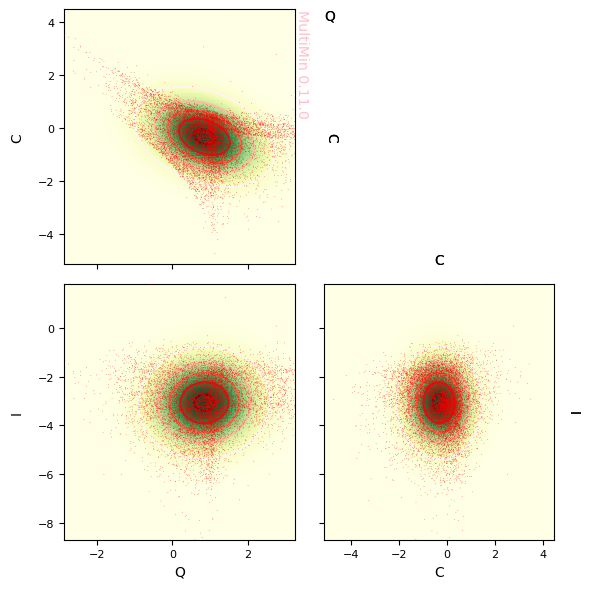

In [31]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.9948867752101287
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8514048609592131, -0.336011068633003, -3.069410279761813]]
    Standard deviations (σ): [[0.8613721856280536, 0.8797944529285945, 1.0755388460240902]]
    Correlation coefficients (ρ): [[-0.32342087822759746, 0.0445503840682846, -0.041324914719789385]]

    Covariant matrices (Σ): 
        [[[0.74196204217365, -0.24509819642105996, 0.04127322424873879], [-0.24509819642105996, 0.7740382794039249, -0.039103829100583694], [0.04127322424873879, -0.039103829100583694, 1.1567838093068317]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8514048609592131, -0.336011068633003

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.993694115753112


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.8119411468505859 seconds
Elapsed time since last call: 812.02 ms
-log(L)/N = 3.8996952151886255
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.31272028888507575, 0.6872797111149243]
    Number of variables: 3
    Averages (μ): [[0.40465419332865643, 0.38692237822540354, -3.457478370825141], [1.0413011082329524, -0.6476507959418326, -2.904538265414511]]
    Standard deviations (σ): [[0.8428851284219802, 0.5911573747614239, 1.2235405522373484], [0.7934294163446116, 0.791775519588033, 0.9551134352238501]]
    Correlation coefficients (ρ): [[-0.7427156152183945, -0.35173955378345034, 0.3087499057195411], [0.026940590048388113, 0.14904901689730488, 0.023333786379778898]]

    Covariant matrices (Σ): 
        [[[0.710455339714938, -0.3700786728774504, -0.3627504564365279], [-0.3700786728774504, 0.34946704173481863, 0.22332035697068212], [-0.3627504564365279, 0.22332035697068212, 1.4970514829692754]], [[0.629530238

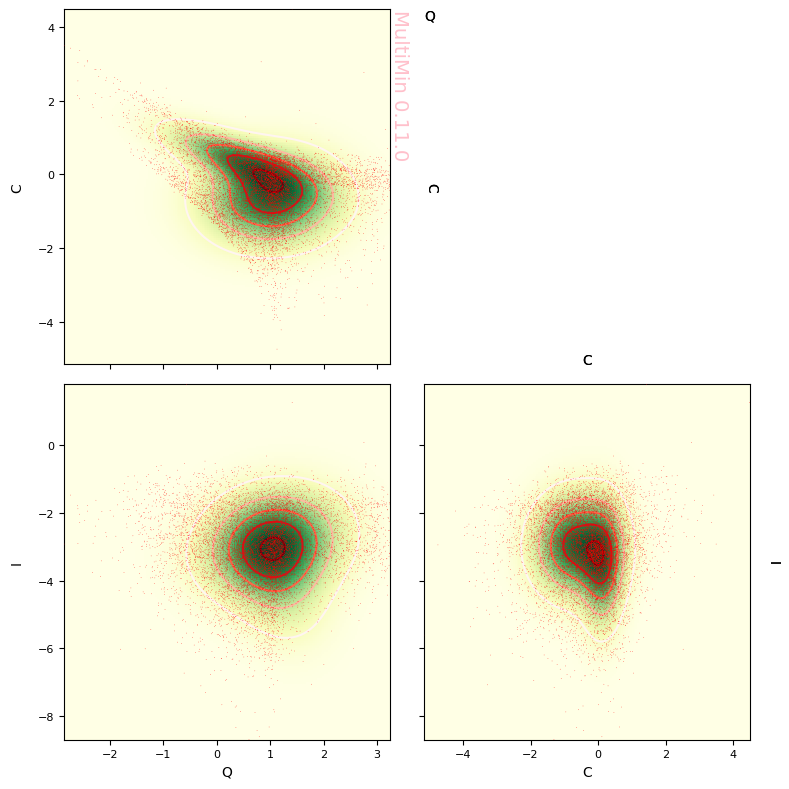

In [34]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.993694115753112


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.8637421131134033 seconds
Elapsed time since last call: 863.849 ms
-log(L)/N = 3.899699751593572
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.3128693540488063, 0.6871306459511938]
    Number of variables: 3
    Averages (μ): [[0.40429954872746304, 0.3867642762921325, -3.4573674824884417], [1.0415296870731527, -0.6477660842073483, -2.9044430755820647]]
    Standard deviations (σ): [[0.8427288402901887, 0.5912041129684247, 1.2236091199094388], [0.7933390708175125, 0.7917897900071894, 0.9549893438591889]]
    Correlation coefficients (ρ): [[-0.7423886739212042, -0.35171772687960734, 0.3085831224577664], [0.027189963530130923, 0.14907894784952336, 0.023336632998698592]]

    Covariant matrices (Σ): 
        [[[0.7101918982568464, -0.3698764162902779, -0.3626810127259832], [-0.3698764162902779, 0.34952230319078187, 0.22322987764793334], [-0.3626810127259832, 0.22322987764793334, 1.4972192783255514]], [[0.6293868

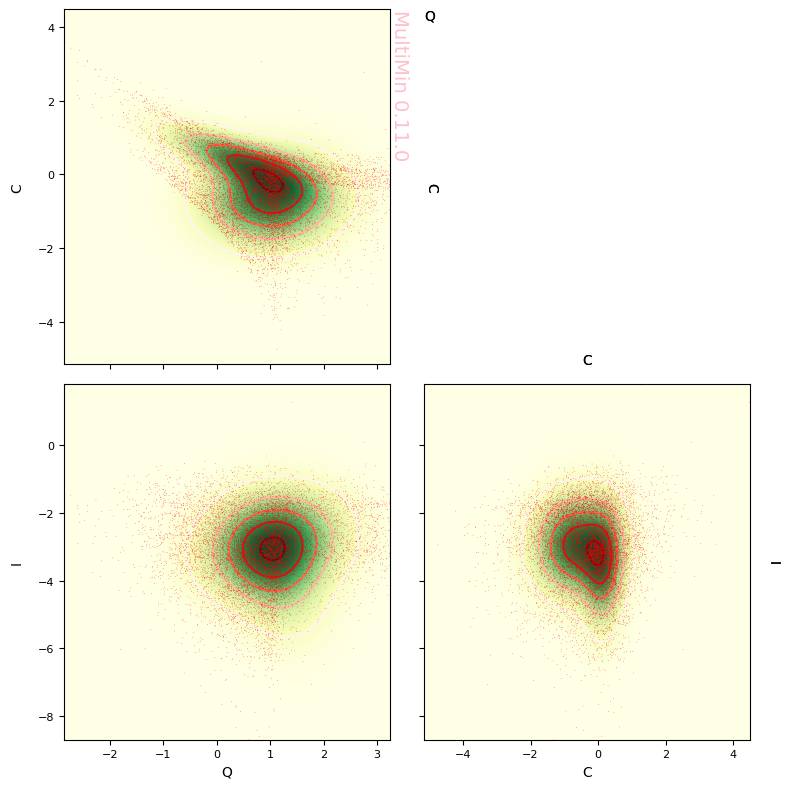

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.993694115753112


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 14.795501947402954 seconds
Elapsed time since last call: 14.7959 s
-log(L)/N = 3.7359314967687736
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.09234123437773492, 0.33720860501822186, 0.10093064527187816, 0.23559535567880507, 0.23392415965336]
    Number of variables: 3
    Averages (μ): [[1.7552354181282237, -0.7762760222936899, -3.4603070561357963], [0.9980219957354306, -0.6016211215322559, -2.963170451312035], [0.38450323776492445, 0.6764531323029036, -3.6639069536259465], [1.2871359558342874, 0.13565434694149356, -3.185897901524761], [0.026116905408168332, -0.6294947701161436, -2.6743269563538723]]
    Standard deviations (σ): [[0.8278145943949581, 0.8123577676261787, 1.5876117701052637], [0.36931589001100096, 0.5961068335458193, 0.9517445666721938], [0.6799113709310085, 0.4081125705075221, 1.2239883303000287], [0.8528975994021423, 0.28521467525069705, 0.8295837310892441], [0.7256643913435635, 1.184196928

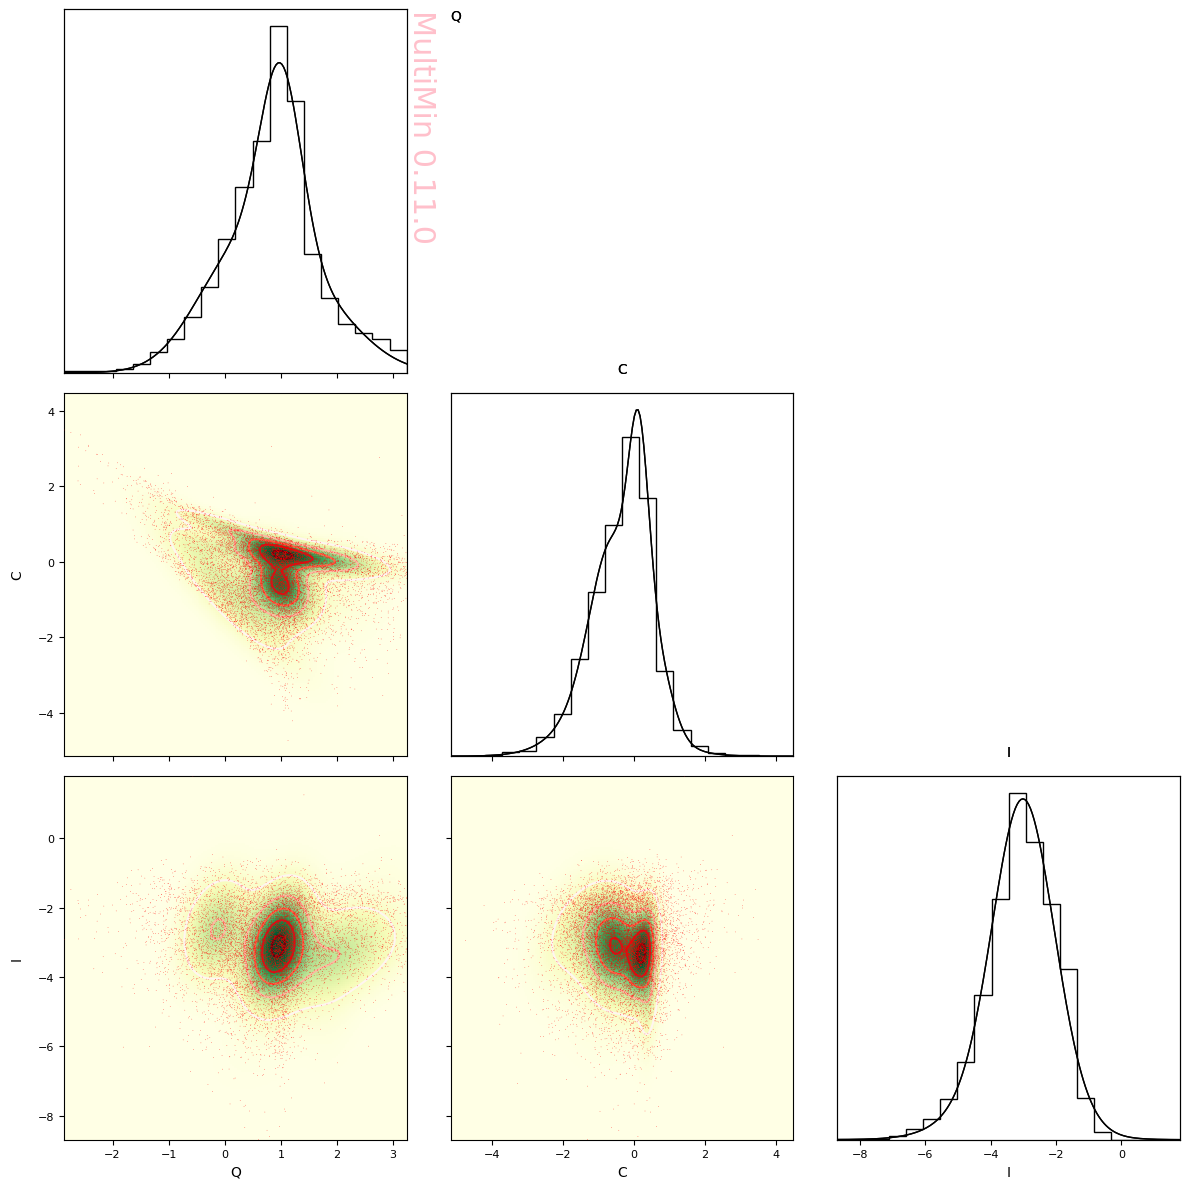

In [36]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            marginals=True,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

MixtureOfGaussians.rvs executed in 0.4755828380584717 seconds


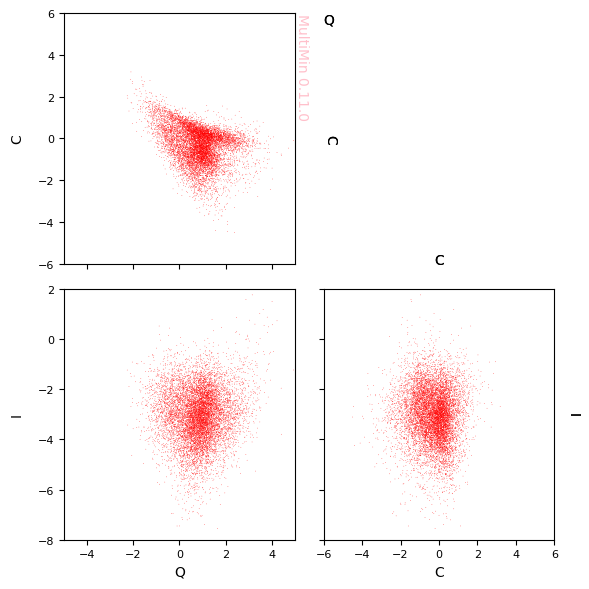

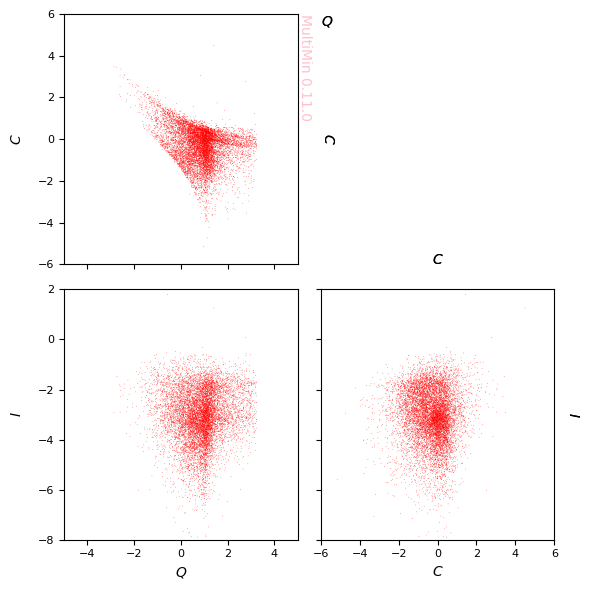

In [37]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

Let's compare them through its marginals:

MixtureOfGaussians.rvs executed in 0.47720789909362793 seconds


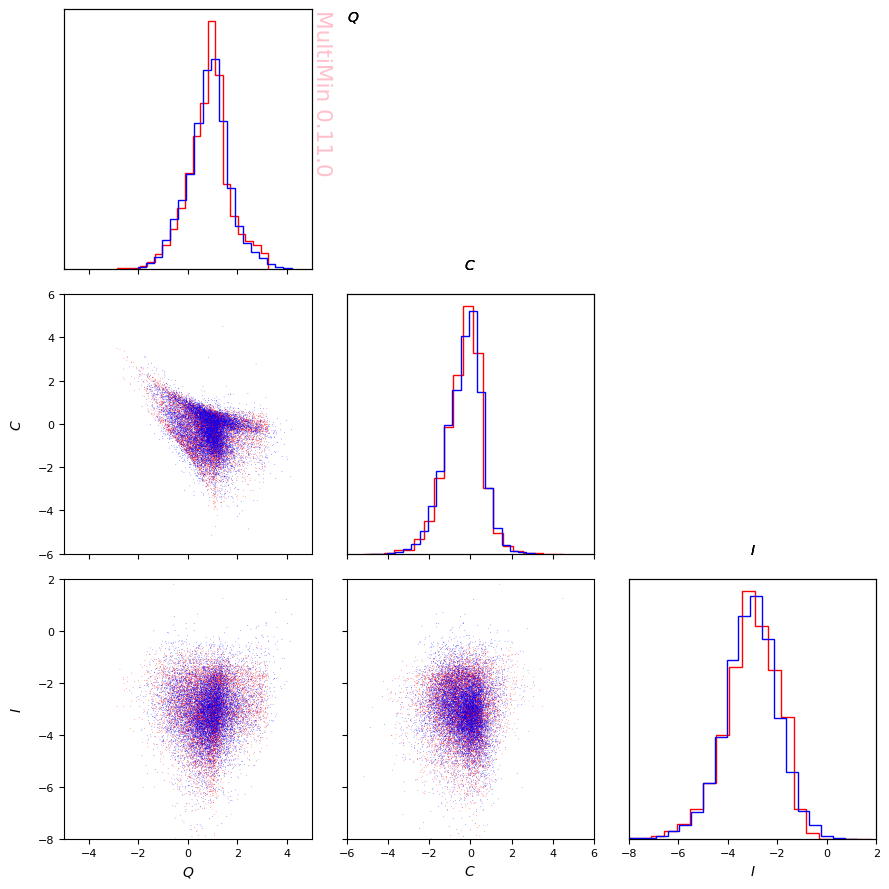

In [38]:
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3,marginals=True)

sargs=dict(s=0.2,edgecolor='None',color='r',margs=dict(color='r'))
hist=G.sample_scatter(udata,**sargs)

sample = F.mog.rvs(len(udata))
sargs=dict(s=0.2,edgecolor='None',color='b',margs=dict(color='b'))
G.sample_scatter(sample,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

MixtureOfGaussians.rvs executed in 0.4756278991699219 seconds


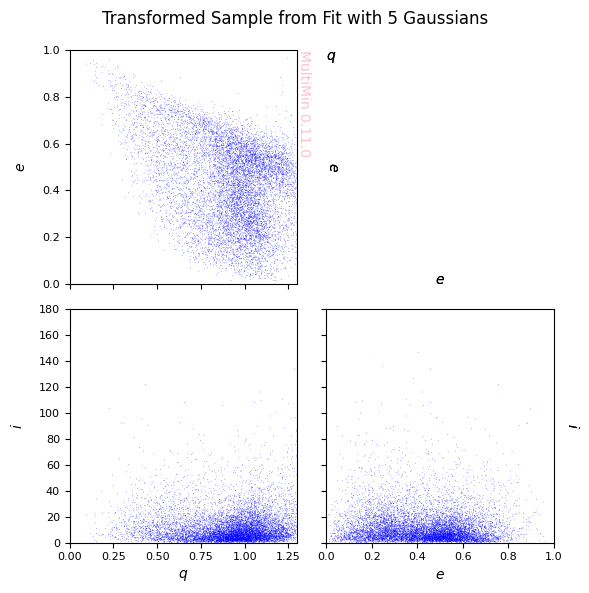

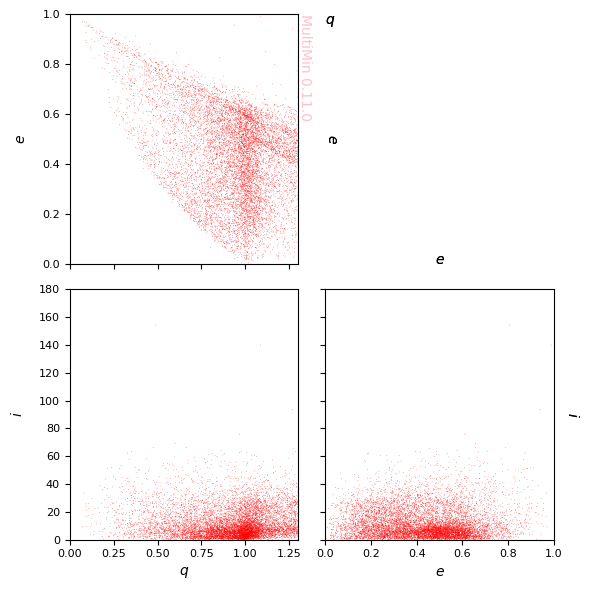

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

And their marginals:

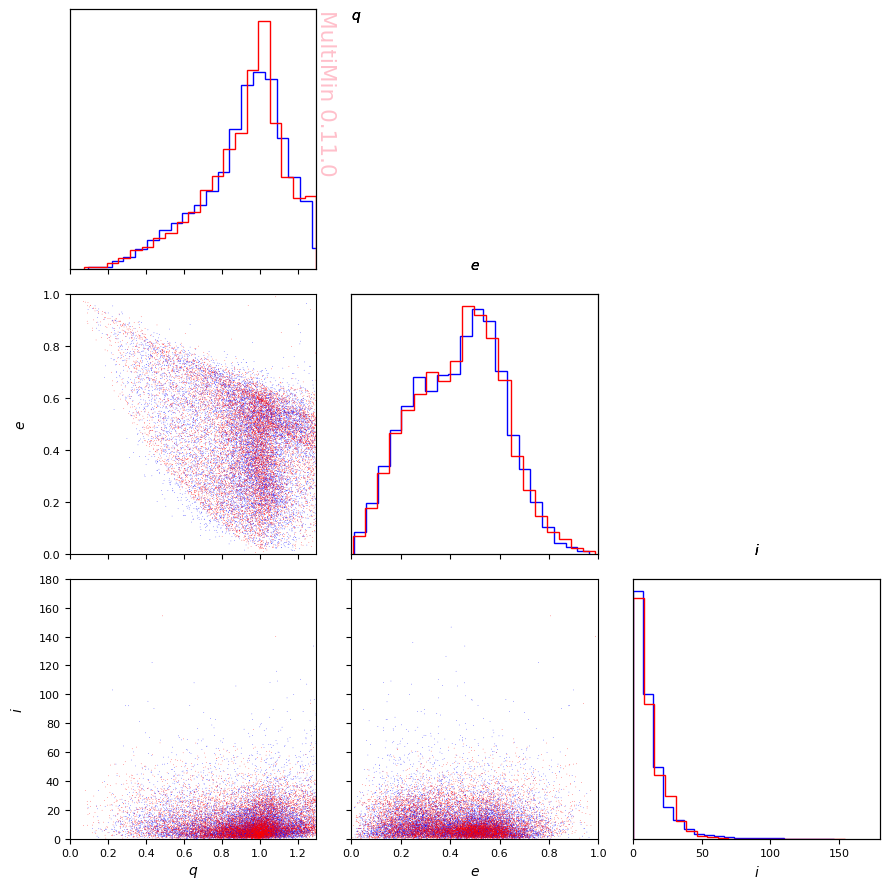

In [41]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3, marginals=True)
sargs=dict(s=0.2,edgecolor='None',color='b',margs=dict(color='b'))
scatter_transformed=Gt.sample_scatter(rsample,**sargs)

sargs=dict(s=0.2,edgecolor='None',color='r',margs=dict(color='r'))
scatter_original=Gt.sample_scatter(data_neas_qei,**sargs)

In [42]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 1.755235
    mu1_e = -0.776276
    mu1_i = -3.460307
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.685277, -0.018957, 0.975351], [-0.018957, 0.659925, -0.04696], [0.975351, -0.04696, 2.520511]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 0.998022
    mu2_e = -0.601621
    mu2_i = -2.96317
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.136394, -0.073388, 0.118737], [-0.073388, 0.355343, -0.108595], [0.118737, -0.108595, 0.905818]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 0.384503
    mu3_e = 0.676453
    mu3_i = -3.663907
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.462279, -0.251361, -0.222244], [-0.251361, 0.166556, 0.163435], [-0.222244, 0.163435, 1.498147]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 1.287136
    mu4_e = 0.135654
    mu4_i = -3.185898
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.727434, -0.130769, 0.182071], [-0.130769, 0.081347, 0.033077], [0.182071, 0.033077, 0.688209]]
    n4 = Util.nmd(

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga